In [36]:
%pip install --quiet --upgrade matplotlib
%pip install --quiet --editable energyplus-extras matplotlib-extras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib widget

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib_extras as mplx
import matplotlib_extras.animation
import matplotlib_extras.lines

In [23]:
import ooep
import ooep.utils
import ooep.ems

In [29]:
env = ooep.ems.Environment().__enter__()

In [30]:
tmeter = env.variable(dict(
    variable_name='People Air Temperature',
    variable_key='CORE_MID'
))

tstat_cool = env.actuator(dict(
    component_type='Zone Temperature Control',
    control_type='Cooling Setpoint',
    actuator_key='CORE_MID'
))

tstat_heat = env.actuator(dict(
    component_type='Zone Temperature Control',
    control_type='Heating Setpoint',
    actuator_key='CORE_MID'
))

emeter = env.meter(dict(
    meter_name='Electricity:Zone:CORE_MID'
))

In [31]:
import typing

class FunctionLine2D(mplx.lines.Line2D):
    def __init__(
        self, 
        *data_srcs: typing.Callable,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.on_step(
            'append_data', 
            *data_srcs
        )


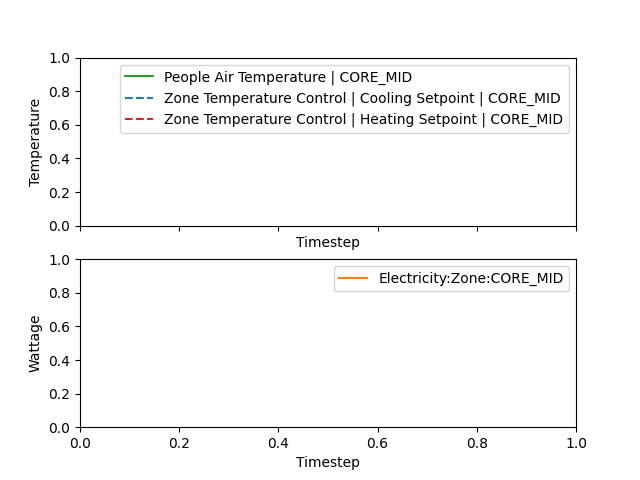

In [32]:
fig, (ax_temp, ax_elec) = plt.subplots(nrows=2, sharex=True)
timestep = 0
animation = mplx.animation.FigureAnimation(
    fig, 
    [
        # temperatures
        ax_temp.add_artist(
            FunctionLine2D(
                lambda: (timestep, tmeter.value),
                label=tmeter.name,
                linestyle='-', 
                color='tab:green'
            )
            .autofit()
        ),
        ax_temp.add_artist(
            FunctionLine2D(
                lambda: (timestep, tstat_cool.value),
                label=tstat_cool.name,
                linestyle='--', 
                color='tab:blue'
            )
            .autofit()
        ),
        ax_temp.add_artist(
            FunctionLine2D(
                lambda: (timestep, tstat_heat.value),
                label=tstat_heat.name,
                linestyle='--', 
                color='tab:red'
            )
            .autofit()
        ),
        # elec
        ax_elec.add_artist(
            FunctionLine2D(
                lambda: (timestep, emeter.value),
                label=emeter.name,
                color='tab:orange'
            )
            .autofit()
        )
    ]
)

ax_temp.set(xlabel='Timestep', ylabel='Temperature')
ax_temp.legend()

ax_elec.set(xlabel='Timestep', ylabel='?')
ax_elec.legend()

import asyncio
loop = asyncio.get_event_loop()

import concurrent.futures
thread_pool = concurrent.futures.ThreadPoolExecutor()

def _f_callback():
    global env, animation, timestep
    if env.warming_up:
        return
    try: 
        # TODO
        #ax.relim()
        #ax.autoscale_view()
        
        animation.step_artists()
        if timestep % 10 == 0:
            # TODO
            loop.run_in_executor(
                thread_pool,
                animation.draw_artists
            )
        timestep += 1
    except ooep.ems.NotReadyError: pass

env.event(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
    #dict(event_name='after_component_input')
).callback = _f_callback

plt.ion()
plt.show(block=False)

In [33]:
env(
    # TODO
    #'--design-day',
    #'--annual',
    '--output-directory', 'build/demo-eplus',
    '--weather', f'{ooep.utils.energyplus.dataset.weathers}/USA_FL_Tampa.Intl.AP.722110_TMY3.epw',
    f'{ooep.utils.energyplus.dataset.models}/ASHRAE901_OfficeLarge_STD2019_Denver_Chiller205_Detailed.idf'
)

0

In [7]:
# TODO async
import cProfile

# TODO
with cProfile.Profile() as pr:
    # ... do something ...
    env(
        # TODO
        '--design-day',
        #'--annual',
        '--output-directory', 'build/demo-eplus',
        '--weather', f'{ooep.utils.energyplus.dataset.weathers}/USA_FL_Tampa.Intl.AP.722110_TMY3.epw',
        f'{ooep.utils.energyplus.dataset.models}/ASHRAE901_OfficeLarge_STD2019_Denver_Chiller205_Detailed.idf'
    )

    pr.print_stats()

         67134 function calls (67128 primitive calls) in 6.369 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      384    0.000    0.000    0.000    0.000 208309888.py:15(<lambda>)
      384    0.001    0.000    0.008    0.000 208309888.py:16(<lambda>)
      192    0.000    0.000    0.000    0.000 208309888.py:28(<lambda>)
      192    0.000    0.000    0.059    0.000 208309888.py:29(<lambda>)
      192    0.000    0.000    0.000    0.000 208309888.py:41(<lambda>)
      192    0.000    0.000    0.052    0.000 208309888.py:42(<lambda>)
     2982    0.008    0.000    0.215    0.000 208309888.py:51(_f_callback)
     1536    0.001    0.000    0.003    0.000 abc.py:117(__instancecheck__)
      5/2    0.000    0.000    0.000    0.000 abc.py:121(__subclasscheck__)
      384    0.003    0.000    0.160    0.000 animation.py:132(step_artists)
      384    0.001    0.000    0.180    0.000 animation.py:143(step_idle)
      192    0.0

In [ ]:
env.__exit__()